# 1. Installing and Importing Dependencies

In [1]:
!apt-get install -y poppler-utils && pip install pdf2image open-clip-torch transformers beautifulsoup4 requests pillow scikit-learn matplotlib seaborn tqdm streamlit -q


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.9 [186 kB]
Fetched 186 kB in 1s (356 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.9_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.9) ...
Setting up poppler-utils (22.02.0-2ubuntu0.9) ...
Processing triggers for man-db (2.10.2-1) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Installed Libraries and Their Use

- `open-clip-torch`: Used for extracting visual+text embeddings using the CLIP model for zero-shot or multimodal tasks.
- `transformers`: Provides access to pre-trained NLP and vision models (like BERT, ViT) from Hugging Face.
- `pdf2image`: Converts PDF pages into images, useful for visual input extraction from documents.
- `beautifulsoup4`: Parses and scrapes HTML/XML content, useful for extracting images or text from web pages.
- `requests`: Used to send HTTP requests and fetch content from URLs (like PDFs or websites).
- `pillow`: A Python Imaging Library for image loading, manipulation, and format conversion.
- `scikit-learn`: Provides essential tools for machine learning, evaluation metrics, preprocessing, and modeling.
- `matplotlib`: Used for plotting data, confusion matrices, image visualizations, etc.
- `seaborn`: Builds on matplotlib to create more attractive and informative statistical graphics.
- `tqdm`: Adds progress bars to loops for better tracking of long-running operations.


In [2]:
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm.auto import tqdm
import requests
from bs4 import BeautifulSoup
import os
import json
import time
import io
import warnings

warnings.filterwarnings('ignore')


In [3]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")

 Using device: cuda


# 2. Image Extraction Utilities

In [4]:
class ImageExtractor:


    def __init__(self):
        self.supported_formats = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp']

    def extract_from_pdf(self, pdf_path, output_dir="extracted_images", dpi=300):
        try:
            from pdf2image import convert_from_path
        except ImportError:
            print("pdf2image not installed. Run: !apt-get install poppler-utils")
            return []
        os.makedirs(output_dir, exist_ok=True)
        extracted_images = []
        try:
            pages = convert_from_path(pdf_path, dpi=dpi)
            for i, page in enumerate(pages):
                image_path = os.path.join(output_dir, f"pdf_page_{i+1}.jpg")
                page.save(image_path, 'JPEG')
                extracted_images.append(image_path)
            print(f"Extracted {len(extracted_images)} images from PDF")
            return extracted_images
        except Exception as e:
            print(f"Error extracting from PDF: {str(e)}")
            return []

    def extract_from_url(self, url, output_dir="extracted_images", max_images=50):
        import requests
        from bs4 import BeautifulSoup
        from urllib.parse import urljoin, urlparse
        os.makedirs(output_dir, exist_ok=True)
        extracted_images = []
        try:
            headers = {'User-Agent': 'Mozilla/5.0 ... Chrome/91.0.4472.124 Safari/537.36'}
            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()
            soup = BeautifulSoup(response.content, 'html.parser')
            img_tags = soup.find_all('img')
            print(f"Found {len(img_tags)} image tags on webpage")
            for i, img in enumerate(img_tags):
                if len(extracted_images) >= max_images:
                    break
                img_url = img.get('src') or img.get('data-src') or img.get('data-lazy-src')
                if not img_url:
                    continue
                img_url = urljoin(url, img_url)
                if any(fmt in img_url.lower() for fmt in self.supported_formats):
                    try:
                        img_response = requests.get(img_url, headers=headers, timeout=5)
                        if img_response.status_code == 200 and len(img_response.content) > 1000:
                            filename = f"web_image_{len(extracted_images)+1}.jpg"
                            image_path = os.path.join(output_dir, filename)
                            img_pil = Image.open(io.BytesIO(img_response.content))
                            if img_pil.mode in ('RGBA', 'LA', 'P'):
                                img_pil = img_pil.convert('RGB')
                            if img_pil.size[0] > 2048 or img_pil.size[1] > 2048:
                                img_pil.thumbnail((2048, 2048), Image.Resampling.LANCZOS)
                            img_pil.save(image_path, 'JPEG', quality=85)
                            extracted_images.append(image_path)
                    except Exception as e:
                        continue
            print(f" Extracted {len(extracted_images)} images from URL")
            return extracted_images
        except Exception as e:
            print(f" Error extracting from URL: {str(e)}")
            return []


# 3.Medical Image Classifier (BiomedCLIP)

In [5]:
class MedicalImageClassifier:


    def __init__(self):
        self.model = None
        self.preprocess = None
        self.tokenizer = None
        self.device = device

    def load_model(self):
        try:
            from open_clip import create_model_from_pretrained, get_tokenizer
        except ImportError:
            print("open_clip_torch not installed properly")
            return False
        print(" Loading BiomedCLIP model...")
        try:
            self.model, self.preprocess = create_model_from_pretrained(
                'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
            )
            self.tokenizer = get_tokenizer(
                'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
            )
            self.model.to(self.device)
            self.model.eval()
            print(f"Model loaded successfully on {self.device}")
            # Define prompts and labels
            self.templates = [
                'this is a photo of', 'this image shows', 'this is an image of', 'a photograph of'
            ]
            self.medical_labels = [
                'medical image', 'X-ray image', 'MRI scan', 'CT scan', 'ultrasound image',
                'histopathology image', 'medical photograph', 'radiological image', 'clinical image',
                'diagnostic image', 'medical chart', 'anatomical image'
            ]
            self.non_medical_labels = [
                'non-medical image', 'natural photograph', 'landscape photo', 'portrait photo',
                'everyday object', 'architectural photo', 'animal photo', 'food photo', 'abstract image',
                'general photograph', 'street scene', 'artwork'
            ]
            return True
        except Exception as e:
            print(f"Error loading model: {str(e)}")
            return False

    def classify_single_image(self, image_path):
        try:
            image = Image.open(image_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')
            if image.size[0] > 512 or image.size[1] > 512:
              image.thumbnail((512, 512), Image.Resampling.LANCZOS)
            image_tensor = self.preprocess(image).unsqueeze(0).to(self.device)
            all_labels = self.medical_labels + self.non_medical_labels
            text_prompts = [
                f"{template} {label}" for template in self.templates for label in all_labels
            ]
            text_tokens = self.tokenizer(text_prompts, context_length=256).to(self.device)
            with torch.no_grad():
                image_features, text_features, logit_scale = self.model(image_tensor, text_tokens)
                logits = (logit_scale * image_features @ text_features.t()).detach()
                probs = torch.softmax(logits, dim=-1).cpu()
                # Aggregate probabilities
                num_templates = len(self.templates)
                num_labels = len(all_labels)
                probs_reshaped = probs.view(num_templates, num_labels)
                avg_probs = torch.mean(probs_reshaped, dim=0)
                medical_score = torch.sum(avg_probs[:len(self.medical_labels)]).item()
                non_medical_score = torch.sum(avg_probs[len(self.medical_labels):]).item()
                total_score = medical_score + non_medical_score
                medical_confidence = medical_score / total_score if total_score > 0 else 0.5
                prediction = "medical" if medical_confidence > 0.5 else "non-medical"
                confidence = max(medical_confidence, 1 - medical_confidence)
                return {
                    'prediction': prediction,
                    'confidence': confidence,
                    'medical_score': medical_confidence,
                    'non_medical_score': 1 - medical_confidence
                }
        except Exception as e:
            print(f"Error classifying {image_path}: {str(e)}")
            return {'prediction': 'error', 'confidence': 0.0, 'medical_score': 0.0, 'non_medical_score': 0.0}

    def classify_batch(self, image_paths, batch_size=8):
        results = []
        print(f" Classifying {len(image_paths)} images...")
        for i in tqdm(range(0, len(image_paths), batch_size)):
            batch_paths = image_paths[i:i+batch_size]
            for image_path in batch_paths:
                result = self.classify_single_image(image_path)
                result['image_path'] = image_path
                result['image_name'] = os.path.basename(image_path)
                results.append(result)
        return results


# 4. Pipeline: Process Input Source

In [6]:
def process_input(input_source, source_type='auto', extractor=None, classifier=None):

    if extractor is None or classifier is None:
        print("Extractor and classifier must be initialized")
        return None
    print(f" Starting processing pipeline...")
    start_time = time.time()
    # Determine source type
    if source_type == 'auto':
        if input_source.lower().endswith('.pdf'):
            source_type = 'pdf'
        elif input_source.startswith(('http://', 'https://')):
            source_type = 'url'
        else:
            print("Cannot determine input type. Please specify 'pdf' or 'url'")
            return None
    if source_type == 'pdf':
        print(f"Processing PDF: {input_source}")
        image_paths = extractor.extract_from_pdf(input_source)
    elif source_type == 'url':
        print(f"Processing URL: {input_source}")
        image_paths = extractor.extract_from_url(input_source)
    else:
        print("Invalid source type")
        return None
    if not image_paths:
        print("No images extracted")
        return None
    results = classifier.classify_batch(image_paths)
    # Generate summary
    medical_count = sum(1 for r in results if r['prediction'] == 'medical')
    non_medical_count = sum(1 for r in results if r['prediction'] == 'non-medical')
    error_count = sum(1 for r in results if r['prediction'] == 'error')
    processing_time = time.time() - start_time
    print(f"\n Processing Complete!")
    print(f"   Total images processed: {len(results)}")
    print(f"   Medical images: {medical_count}")
    print(f"   Non-medical images: {non_medical_count}")
    print(f"   Errors: {error_count}")
    print(f"   Processing time: {processing_time:.2f} seconds")
    if len(results) > 0:
        print(f"   Average time per image: {processing_time/len(results):.2f} seconds")
    results_df = pd.DataFrame(results)
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    output_file = f"classification_results_{timestamp}.csv"
    results_df.to_csv(output_file, index=False)
    print(f"   Results saved to: {output_file}")
    return {
        'results': results,
        'summary': {
            'total_images': len(results),
            'medical_count': medical_count,
            'non_medical_count': non_medical_count,
            'error_count': error_count,
            'processing_time': processing_time,
            'avg_time_per_image': processing_time/len(results) if len(results) > 0 else 0
        },
        'output_file': output_file
    }


# 5. Result Visualization

In [7]:
def visualize_results(results, max_images=12):
    """Visualize classification results"""
    if 'results' in results:
        display_results = results['results'][:max_images]
    else:
        display_results = results[:max_images]
    n_cols = 4
    n_rows = (len(display_results) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    for i, result in enumerate(display_results):
        if i >= len(axes):
            break
        try:
            img = Image.open(result['image_path'])
            axes[i].imshow(img)
            prediction = result['prediction']
            confidence = result['confidence']
            color = 'green' if prediction in ['medical', 'non-medical'] else 'red'
            title = f"{prediction.title()}\nConf: {confidence:.3f}"
            axes[i].set_title(title, color=color, fontweight='bold')
            axes[i].axis('off')
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Error loading\n{result['image_name']}",
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    # Hide empty subplots
    for i in range(len(display_results), len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


# 6. Testing & Evaluation

In [15]:
import os

print("Medical:", len(os.listdir("/content/sample_data/medical")))
print("Non-Medical:", len(os.listdir("/content/sample_data/non_medical")))


Medical: 20
Non-Medical: 20


In [22]:
def prepare_test_data(medical_dir, non_medical_dir):
    test_data = []
    # Medical
    for fname in os.listdir(medical_dir):
        img_path = os.path.join(medical_dir, fname)
        if os.path.isfile(img_path):
            test_data.append((img_path, 'medical'))
    # Non-medical
    for fname in os.listdir(non_medical_dir):
        img_path = os.path.join(non_medical_dir, fname)
        if os.path.isfile(img_path):
            test_data.append((img_path, 'non-medical'))
    return test_data


In [23]:
medical_dir = "/content/sample_data/medical"
non_medical_dir = "/content/sample_data/non_medical"
test_data = prepare_test_data(medical_dir, non_medical_dir)


In [26]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix


In [27]:


def evaluate_model(test_data, classifier):

    image_paths = [item[0] for item in test_data]
    true_labels = [item[1] for item in test_data]
    results = classifier.classify_batch(image_paths)
    valid_results = [(r, true_labels[i]) for i, r in enumerate(results) if r['prediction'] != 'error']
    if not valid_results:
        print("No valid predictions to evaluate")
        return None
    predictions = [r[0]['prediction'] for r in valid_results]
    valid_true_labels = [r[1] for r in valid_results]

    precision = precision_score(valid_true_labels, predictions, pos_label='medical')
    recall = recall_score(valid_true_labels, predictions, pos_label='medical')
    cm = confusion_matrix(valid_true_labels, predictions)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("Confusion Matrix:")
    print(cm)
    return precision, recall, cm


In [28]:
results = evaluate_model(test_data, classifier)



 Classifying 40 images...


  0%|          | 0/5 [00:00<?, ?it/s]

Precision: 0.9444
Recall: 0.8500
Confusion Matrix:
[[17  3]
 [ 1 19]]


# 7. Main Execution Block

In [29]:
extractor = ImageExtractor()
classifier = MedicalImageClassifier()
classifier.load_model()


 Loading BiomedCLIP model...
Model loaded successfully on cuda


True

In [30]:
if __name__ == "__main__":
    print("Medical Image Classification")

    extractor = ImageExtractor()
    classifier = MedicalImageClassifier()
    if not classifier.load_model():
        print("Failed to load model.")
        exit(1)
    print("\n System ready! You can now:")
    print("1. Process PDF: process_input('mi.pdf', extractor=extractor, classifier=classifier)")
    print("2. Process URL: process_input('Wesbite link', extractor=extractor, classifier=classifier)")
    print("3. Evaluate: test_data = prepare_test_data('medical_dir', 'non_medical_dir')")
    print("             evaluate_model(test_data, classifier)")


Medical Image Classification
 Loading BiomedCLIP model...
Model loaded successfully on cuda

 System ready! You can now:
1. Process PDF: process_input('mi.pdf', extractor=extractor, classifier=classifier)
2. Process URL: process_input('Wesbite link', extractor=extractor, classifier=classifier)
3. Evaluate: test_data = prepare_test_data('medical_dir', 'non_medical_dir')
             evaluate_model(test_data, classifier)


In [31]:
results = process_input('mi.pdf', extractor=extractor, classifier=classifier)


 Starting processing pipeline...
Processing PDF: mi.pdf
Extracted 20 images from PDF
 Classifying 20 images...


  0%|          | 0/3 [00:00<?, ?it/s]


 Processing Complete!
   Total images processed: 20
   Medical images: 9
   Non-medical images: 11
   Errors: 0
   Processing time: 29.96 seconds
   Average time per image: 1.50 seconds
   Results saved to: classification_results_20250810_033626.csv


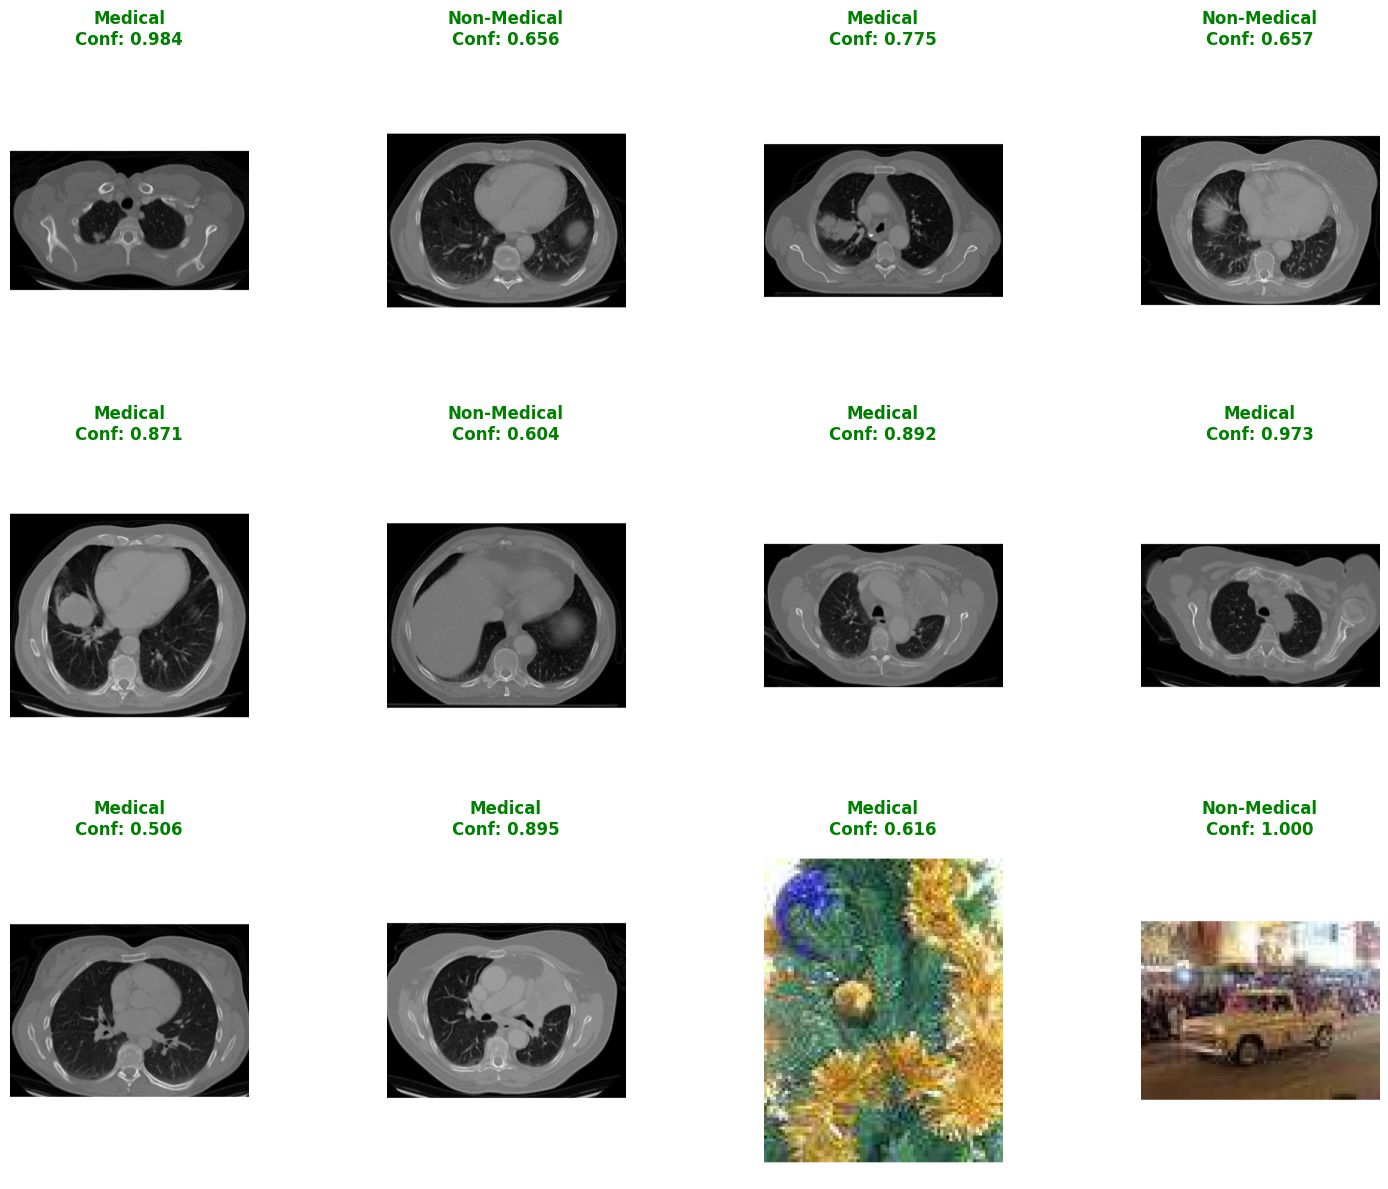

In [32]:
visualize_results(results)
